<a href="https://colab.research.google.com/github/ambideXtrous9/GAN/blob/main/GAN2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --quiet pytorch-lightning

In [2]:
import tensorflow as tf
import json
import os
import cv2
from torch.nn import functional as F
from pathlib import Path
import torchvision
from google.colab.patches import cv2_imshow
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from pathlib import Path
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from torch import nn
import PIL
import torchvision.models as models

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split

In [3]:
pl.seed_everything(42)

INFO:lightning_fabric.utilities.seed:Global seed set to 42


42

In [4]:
_URL = 'http://images.cocodataset.org/zips/val2014.zip'
zip_dir = tf.keras.utils.get_file('/content/MSCOCOVAL2014.zip', origin=_URL, extract=False,archive_format='auto')
fname = '/content/MSCOCOVAL2014.zip'
!unzip -q $fname -d /content/

6645013297/6645013297 [==============================] - 130s 0us/step


In [5]:
_URL = 'https://s3.amazonaws.com/cvmlp/vqa/mscoco/vqa/v2_Questions_Val_mscoco.zip'
zip_dir = tf.keras.utils.get_file('/content/QUESVAL2014.zip', origin=_URL, extract=False,archive_format='auto')
fname = '/content/QUESVAL2014.zip'
!unzip -q $fname -d /content/

3494929/3494929 [==============================] - 0s 0us/step


In [6]:
_URL = 'https://s3.amazonaws.com/cvmlp/vqa/mscoco/vqa/v2_Annotations_Val_mscoco.zip'
zip_dir = tf.keras.utils.get_file('/content/ANNOTVAL2014.zip', origin=_URL, extract=False,archive_format='auto')
fname = '/content/ANNOTVAL2014.zip'
!unzip -q $fname -d /content/

10518930/10518930 [==============================] - 0s 0us/step


In [3]:
with open(os.path.join('/content/', 'v2_OpenEnded_mscoco_val2014_questions.json'), 'r') as f:
    val_questions = json.load(f)['questions']
with open(os.path.join('/content/', 'v2_mscoco_val2014_annotations.json'), 'r') as f:
    val_answers = json.load(f)['annotations']

In [4]:
val_data = []
for question, annotation in zip(val_questions, val_answers):
    question_text = question['question']
    image_id = annotation['image_id']
    answer = annotation['answers'][0]['answer']
    image_filename = 'COCO_val2014_{:012d}.jpg'.format(image_id)
    image_path = os.path.join('/content/', 'val2014', image_filename)
    val_data.append({'question': question_text, 'image_path': image_path, 'answer': answer})

In [5]:
# Convert the array of dictionaries to a DataFrame
df = pd.DataFrame(val_data)

In [6]:
def has_three_channels(image_path):
    with PIL.Image.open(image_path) as img:
        return img.mode == 'RGB'

# Filter the DataFrame to keep only the images with 3 channels
df = df[df['image_path'].apply(has_three_channels)]

In [7]:
def show_sample(idx=0):
  print("Q : ",df.iloc[idx]['question'])
  image = cv2.imread(df.iloc[idx]['image_path'])
  image = cv2.resize(image, (224, 224))  
  cv2_imshow(image)
  print("A : ",df.iloc[idx]['answer'])

Q :  What is the background metal structure?


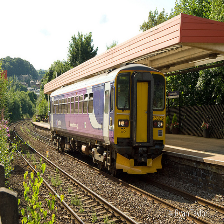

A :  trees


In [8]:
show_sample(100)

# **Model**

In [9]:
df = df[:10000]

In [10]:
train_df, val_df = train_test_split(df,test_size=0.1)

In [93]:
transform = transforms.Compose([
            transforms.Resize(64),
            transforms.CenterCrop(64),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        ])

In [56]:
val_transform = transforms.Compose([
            transforms.Resize(64),
            transforms.CenterCrop(64),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        ])

In [57]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

class ImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['image_path']
        image = Image.open(img_path)
        if self.transform:
            image = self.transform(image)
        
        return dict(img = image)

class ImageDataModule(pl.LightningDataModule):
    def __init__(self, train_df, val_df, batch_size=8, num_workers=4, transform=None):
        super().__init__()
        self.train_df = train_df
        self.val_df = val_df
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.transform = transform
        self.val_transform = val_transform

    def setup(self, stage=None):
        self.train_dataset = ImageDataset(self.train_df, transform=self.transform)
        self.val_dataset = ImageDataset(self.val_df, transform=self.val_transform)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, num_workers=self.num_workers, shuffle=True, pin_memory=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, num_workers=self.num_workers, pin_memory=True)

    def test_dataloader(self):
        return None # No test dataset


In [58]:
class Generator(nn.Module):
    def __init__(self, latent_dim: int):
        super().__init__()
        self.latent_dim = latent_dim
        self.fc = nn.Linear(latent_dim, 1024 * 4 * 4)
        self.conv1 = nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1)
        self.conv4 = nn.ConvTranspose2d(128, 3, kernel_size=4, stride=2, padding=1)

    def forward(self, z):
        x = self.fc(z)
        x = x.view(-1, 1024, 4, 4)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = torch.tanh(self.conv4(x))
        return x

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1)
        self.fc = nn.Linear(512 * 4 * 4, 1)

    def forward(self, x):
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.leaky_relu(self.conv2(x), 0.2)
        x = F.leaky_relu(self.conv3(x), 0.2)
        x = F.leaky_relu(self.conv4(x), 0.2)
        x = x.view(-1, 512 * 4 * 4)
        x = torch.sigmoid(self.fc(x))
        return x

In [59]:
class GAN(pl.LightningModule):
    def __init__(self, latent_dim: int = 512, lr: float = 0.0002, b1: float = 0.5, b2: float = 0.999):
        super().__init__()
        self.save_hyperparameters()
        self.generator = Generator(latent_dim)
        self.discriminator = Discriminator()

    def forward(self, z):
        return self.generator(z)

    def training_step(self, batch, batch_idx, optimizer_idx):
        real_images = batch['img']
        batch_size = real_images.size(0)
        device = real_images.device
        valid = torch.ones(batch_size, 1, device=device)
        fake = torch.zeros(batch_size, 1, device=device)

        if optimizer_idx == 0: # Train generator
            z = torch.randn(batch_size, self.hparams.latent_dim, device=device)
            gen_images = self.generator(z)
            g_loss = F.binary_cross_entropy(self.discriminator(gen_images), valid)
            self.log('g_loss', g_loss)
            return g_loss
        else: # Train discriminator
            z = torch.randn(batch_size, self.hparams.latent_dim, device=device)
            gen_images = self.generator(z).detach()

            real_loss = F.binary_cross_entropy(self.discriminator(real_images), valid)
            fake_loss = F.binary_cross_entropy(self.discriminator(gen_images), fake)
            d_loss = (real_loss + fake_loss) / 2
            self.log('d_loss', d_loss)
            return d_loss

    def validation_step(self, batch, batch_idx):
        real_images = batch['img']
        batch_size = real_images.size(0)
        device = real_images.device
        valid = torch.ones(batch_size, 1, device=device)
        fake = torch.zeros(batch_size, 1, device=device)

        z = torch.randn(batch_size, self.hparams.latent_dim, device=device)
        gen_images = self.generator(z).detach()

        real_loss = F.binary_cross_entropy(self.discriminator(real_images), valid)
        fake_loss = F.binary_cross_entropy(self.discriminator(gen_images), fake)
        d_loss = (real_loss + fake_loss) / 2
        self.log('val_loss', d_loss, prog_bar=True)

    def configure_optimizers(self):
        lr = self.hparams.lr
        betas = (self.hparams.b1, self.hparams.b2)
        opt_g = torch.optim.Adam(self.generator.parameters(), lr=lr, betas=betas)
        opt_d = torch.optim.Adam(self.discriminator.parameters(), lr=lr, betas=betas)
        return [opt_g, opt_d], []

    def train_epoch_end(self):
        z = torch.randn(8, self.hparams.latent_dim, device=self.device)
        sample_imgs = self.generator(z)
        grid = torchvision.utils.make_grid(sample_imgs, nrow=4, normalize=True)
        self.logger.experiment.add_image('generated_images', grid, global_step=self.current_epoch)


In [60]:
BATCH_SIZE = 32
N_EPOCHS = 50

In [61]:
data_module = ImageDataModule(train_df, val_df, batch_size=BATCH_SIZE, 
                              num_workers=4, transform=transform)
data_module.setup()

In [62]:
model = GAN()

In [63]:
checkpoint_callback = ModelCheckpoint(
    dirpath = 'checkpoints',
    filename = 'best_cp',
    save_top_k = 1,
    verbose = True,
    monitor = 'd_loss',
    mode = 'min')

In [64]:
trainer = pl.Trainer(gpus=1,
    callbacks=[checkpoint_callback],
    max_epochs = N_EPOCHS)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [65]:
trainer.fit(model,data_module)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type          | Params
------------------------------------------------
0 | generator     | Generator     | 19.4 M
1 | discriminator | Discriminator | 2.8 M 
------------------------------------------------
22.2 M    Trainable params
0         Non-trainable params
22.2 M    Total params
88.747    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 564: 'd_loss' reached 0.54144 (best 0.54144), saving model to '/content/checkpoints/best_cp.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 1128: 'd_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 1692: 'd_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 2256: 'd_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 2820: 'd_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 5, global step 3384: 'd_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 6, global step 3948: 'd_loss' reached 0.39624 (best 0.39624), saving model to '/content/checkpoints/best_cp.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 7, global step 4512: 'd_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 8, global step 5076: 'd_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 9, global step 5640: 'd_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 10, global step 6204: 'd_loss' reached 0.29326 (best 0.29326), saving model to '/content/checkpoints/best_cp.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 11, global step 6768: 'd_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 12, global step 7332: 'd_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 13, global step 7896: 'd_loss' reached 0.27959 (best 0.27959), saving model to '/content/checkpoints/best_cp.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 14, global step 8460: 'd_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 15, global step 9024: 'd_loss' reached 0.24992 (best 0.24992), saving model to '/content/checkpoints/best_cp.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 16, global step 9588: 'd_loss' reached 0.20491 (best 0.20491), saving model to '/content/checkpoints/best_cp.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 17, global step 10152: 'd_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 18, global step 10716: 'd_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 19, global step 11280: 'd_loss' reached 0.07408 (best 0.07408), saving model to '/content/checkpoints/best_cp.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 20, global step 11844: 'd_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 21, global step 12408: 'd_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 22, global step 12972: 'd_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 23, global step 13536: 'd_loss' reached 0.03051 (best 0.03051), saving model to '/content/checkpoints/best_cp.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 24, global step 14100: 'd_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 25, global step 14664: 'd_loss' reached 0.02071 (best 0.02071), saving model to '/content/checkpoints/best_cp.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 26, global step 15228: 'd_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 27, global step 15792: 'd_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 28, global step 16356: 'd_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 29, global step 16920: 'd_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 30, global step 17484: 'd_loss' reached 0.01483 (best 0.01483), saving model to '/content/checkpoints/best_cp.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 31, global step 18048: 'd_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 32, global step 18612: 'd_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 33, global step 19176: 'd_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 34, global step 19740: 'd_loss' reached 0.00397 (best 0.00397), saving model to '/content/checkpoints/best_cp.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 35, global step 20304: 'd_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 36, global step 20868: 'd_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 37, global step 21432: 'd_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 38, global step 21996: 'd_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 39, global step 22560: 'd_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 40, global step 23124: 'd_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 41, global step 23688: 'd_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 42, global step 24252: 'd_loss' reached 0.00272 (best 0.00272), saving model to '/content/checkpoints/best_cp.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 43, global step 24816: 'd_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 44, global step 25380: 'd_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 45, global step 25944: 'd_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 46, global step 26508: 'd_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 47, global step 27072: 'd_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 48, global step 27636: 'd_loss' reached 0.00132 (best 0.00132), saving model to '/content/checkpoints/best_cp.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 49, global step 28200: 'd_loss' was not in top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


In [66]:
# Load the saved checkpoint
checkpoint_path = "/content/checkpoints/best_cp.ckpt"
model = GAN.load_from_checkpoint(checkpoint_path)

# Put the model in evaluation mode
model.eval()

GAN(
  (generator): Generator(
    (fc): Linear(in_features=512, out_features=16384, bias=True)
    (conv1): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv2): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv4): ConvTranspose2d(128, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
  (discriminator): Discriminator(
    (conv1): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv4): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (fc): Linear(in_features=8192, out_features=1, bias=True)
  )
)

In [67]:
import matplotlib.pyplot as plt

In [145]:
def generate_image(model, image_path, transform=None):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    img = cv2.imread(image_path)
    img = cv2.resize(img, (224, 224))
    cv2_imshow(img)

    transform = transforms.Compose([
            transforms.Resize((64,64)),
            transforms.ToTensor()
        ])

    # Load and transform the input image
    input_image = Image.open(image_path).convert('RGB')
    print(input_image.size)
    input_image = transform(input_image).permute(1, 2, 0).unsqueeze(0).to(device)

    print(input_image.shape)

    with torch.no_grad():
        # Generate the output image
        z = torch.randn(1, model.hparams.latent_dim, device=device)
        output_image = model.generator(z)
        output_image = (output_image + 1) / 2  # Convert the output to a valid image range (0, 1)

        
    output_image = output_image.detach().squeeze().permute(1, 2, 0).cpu().numpy()
    print(output_image.shape)
    # Multiply the pixel values by 255 and clip to the valid range
    output_image = (output_image * 255).astype(np.uint8)
    # Display the input and output images using cv2
    output_image = cv2.resize(output_image, (224, 224))
    cv2_imshow(output_image)


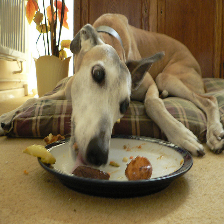

(640, 480)
torch.Size([1, 64, 64, 3])
(64, 64, 3)


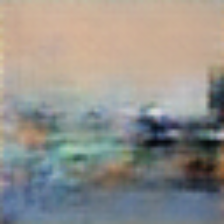

In [146]:
image_path = val_df.iloc[5]['image_path']
generate_image(model, image_path)
